# Confidence Intervals

This notebook overviews three types of intervals that scalecast offers across several model classes and three different datasets. The efficacy of each interval is scored with [Mean Scaled Interval Score (MSIS)](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#src.scalecast.util.metrics.msis).  

**Definition of terms:**  

* *Bootstrapped Intervals (default):* 
  - This is a computationally cheap method that works by drawing randomly from in-sample residuals and measuring distance from actual values.  
  - It is not dynamic (interval ranges are constant throughout a given horizon).  
  - Models that are overfit usually get an extremely tight (and inaccurate) confidence interval.  
  - All scalecast models get this interval by default for any model run with `auto_forecast()` or `manual_forecast()`.
  - Models run with `proba_forecast()` receive a probabilistic confidence interval, but that is not overviewed in this notebook.  
* *Naive Intervals:*
  - This method determines a range of possible values within a given certainty for out-of-sample point predictions by measuring how far different model classes' precitions are from one another in each step of a given horizon.  
  - It can create a dynamic interval that expands as predictions move further out.  
  - If you call a diverse set of models on the same series, this method could give a robust interval.  
  - If models are very close to each but very far from an actual value, it will give an interval that is too tight.  
  - If one model is an outlier in how close or far it is from actual values, it can skew all confidence intervals.  
  - In scalecast, it is computationally cheap and has to be called explicitly in order for models to receive it.  
  - In the examples explored in this notebook, **it generally performed better than the default interval.**  
* *Backtest Intervals:*
  - This method determines confidence intervals by backtesting a given model on out-of-sample forecast horizons.
  - The ranges of the resulting confidence intervals are determined by the standard deviation of each step in each backtest iteration.  
  - This is a computationally expensive method but it results in a dynamic interval that is **generally better than the bootstrapped and naive methods.**    
  
Each one of these intervals were better than and worse than the others at times (according to MSIS) depending on the series being forecast and the model. To evaluate the intervals, we leave out a section of each series to score out-of-sample. This is usually not necessary for scalecast, as all models are tested automatically, but the backtest confidence interval can overfit on any test set stored in the `Forecaster` object. Every scalecast framework scored better than using confidence intervals from ARIMA. The series used in this example are ordered from easiest-to-hardest to forecast. Different results could be obtained if certain parameters are changed, such as the model classes used and the number of backtest iterations for that interval type.  

**Sections:**  
[Daily Website Visitors](#Daily-Website-Visitors)  
[Housing Starts](#Housing-Starts)  
[Avocado Sales](#Avocado-Sales)  
[All Aggregated Results](#All-Aggregated-Results)  
[Benchmark Against StatsModels ARIMA](#Benchmark-Against-StatsModels-ARIMA)  

In [120]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast import GridGenerator
from scalecast.util import metrics
from scalecast.notebook import tune_test_forecast
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [61]:
models = (
    'mlr',
    'elasticnet',
    'ridge',
    'knn',
    'xgboost',
    'lightgbm',
    'gbt',
)

results_template = pd.DataFrame(index=models)

In [62]:
def score_cis(results, fcsts, ci_name, actuals, obs, val_len, models=models, m_=1):
    for m in models:
        results.loc[m,ci_name] = metrics.msis(
            a = actuals,
            uf = fcsts[m+'_upperci'],
            lf = fcsts[m+'_lowerci'],
            obs = obs,
            m = m_,
        )
    return results

In [4]:
GridGenerator.get_example_grids()

## Daily Website Visitors

- Link to data: https://www.kaggle.com/datasets/bobnau/daily-website-visitors  
- We will use a length of 180 observations (about half a year) both to tune and test the models  
- We want to optimize the forecasts and confidence intervals for a 60-day forecast horizon  

In [5]:
val_len = 180
fcst_len = 60

In [6]:
data = pd.read_csv('daily-website-visitors.csv',parse_dates=['Date']).set_index('Date')
data.head()

Row        Day  Day.Of.Week Page.Loads Unique.Visits  \
Date                                                               
2014-09-14    1     Sunday            1      2,146         1,582   
2014-09-15    2     Monday            2      3,621         2,528   
2014-09-16    3    Tuesday            3      3,698         2,630   
2014-09-17    4  Wednesday            4      3,667         2,614   
2014-09-18    5   Thursday            5      3,316         2,366   

            First.Time.Visits Returning.Visits  
Date                                            
2014-09-14               1430              152  
2014-09-15               2297              231  
2014-09-16               2352              278  
2014-09-17               2327              287  
2014-09-18               2130              236

In [7]:
visits_sep = data['First.Time.Visits'].iloc[-fcst_len:]
visits = data['First.Time.Visits'].iloc[:-fcst_len]

In [8]:
f=Forecaster(
    y=visits,
    current_dates=visits.index,
    future_dates=fcst_len
)
f.set_test_length(val_len)
f.set_validation_length(val_len)
f.auto_Xvar_select(
    estimator='elasticnet',
    alpha=.2,
    max_ar=100,
    monitor='ValidationMetricValue', # not test set
)
f

Forecaster(
    DateStartActuals=2014-09-14T00:00:00.000000000
    DateEndActuals=2020-06-20T00:00:00.000000000
    Freq=D
    N_actuals=2107
    ForecastLength=60
    Xvars=['t', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53', 'AR54', 'AR55', 'AR56', 'AR57', 'AR58', 'AR59', 'AR60', 'AR61', 'AR62', 'AR63', 'AR64', 'AR65', 'AR66', 'AR67', 'AR68', 'AR69', 'AR70', 'AR71', 'AR72', 'AR73', 'AR74', 'AR75', 'AR76', 'AR77', 'AR78', 'AR79', 'AR80', 'AR81', 'AR82', 'AR83', 'AR84', 'AR85', 'AR86', 'AR87', 'AR88', 'AR89', 'AR90', 'AR91', 'AR92', 'AR93', 'AR94', 'AR95', 'AR96', 'AR97', 'AR98', 'AR99', 'AR100']
    Differenced=0
    TestLe

In [9]:
tune_test_forecast(
    f,
    models,
    dynamic_testing = fcst_len,
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [10]:
ms = f.export('model_summaries',determine_best_by='TestSetMAE')
best_model = ms['ModelNickname'].values[0]
ms[['ModelNickname','TestSetMAE','InSampleMAE']]

ModelNickname  TestSetMAE  InSampleMAE
0       xgboost  345.792972    11.628271
1      lightgbm  461.362673    85.150035
2    elasticnet  541.722274   139.726881
3         ridge  543.778908   139.716351
4           mlr  547.506781   140.103644
5           knn  671.790741   217.559589
6           gbt  891.242493   113.251078

We will demonstrate how the confidence intervals change as they are re-evaluated using the best model according to the test MAE: xgboost.

### Bootstrapped Interval (default)

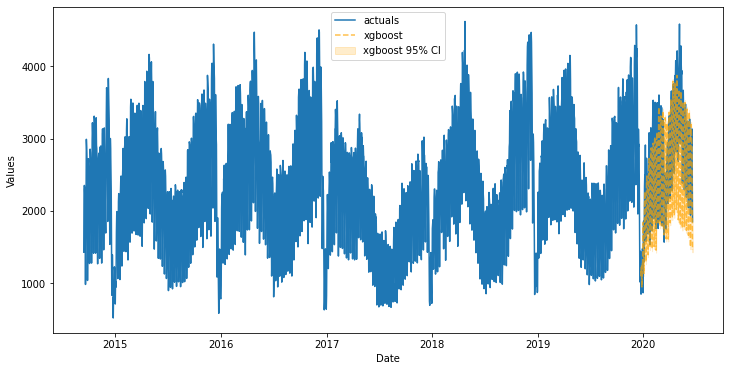

In [11]:
f.plot_test_set(ci=True,models=best_model)
plt.show()

XGBoost overfit on this dataset, so its default confidence interval is barely noticeable. That is one of the downsides of the bootstrapped method from in-sample residuals.

In [12]:
# export test-set preds and confidence intervals
fcsts1 = f.export("lvl_fcsts",cis=True)
fcsts1.head()

DATE      xgboost  xgboost_upperci  xgboost_lowerci     lightgbm  \
0 2020-06-21  2028.825562      2062.677614      1994.973509  2198.858468   
1 2020-06-22  2720.898438      2754.750490      2687.046385  2820.575637   
2 2020-06-23  2845.472412      2879.324465      2811.620359  2819.654176   
3 2020-06-24  2904.729492      2938.581545      2870.877439  2824.992206   
4 2020-06-25  2986.020996      3019.873049      2952.168943  2961.588543   

   lightgbm_upperci  lightgbm_lowerci   elasticnet  elasticnet_upperci  \
0       2453.793311       1943.923624  2199.951838         2501.246250   
1       3075.510480       2565.640793  2837.629387         3138.923800   
2       3074.589019       2564.719332  2963.220499         3264.514912   
3       3079.927050       2570.057362  3026.889266         3328.183678   
4       3216.523387       2706.653700  3024.266925         3325.561338   

   elasticnet_lowerci  ...  ridge_lowerci          mlr  mlr_upperci  \
0         1898.657425  ...    1873.016388  2190.555279  2561.139853   
1         2536.334975  ...    2515.160962  2835.674158  3206.258731   
2         2661.926087  ...    2655.260668  2975.510723  3346.095297   
3         2725.594853  ...    2718.067269  3038.258157  3408.842730   
4         2722.972513  ...    2707.306136  3032.580568  3403.165142   

   mlr_lowerci          knn  knn_upperci  knn_lowerci          gbt  \
0  1819.970706  2080.476190  2735.150407  1425.801974  2125.968510   
1  2465.089584  2962.142857  3616.817073  2307.468641  2729.050006   
2  2604.926150  3038.095238  3692.769454  2383.421022  2880.262061   
3  2667.673583  3128.095238  3782.769454  2473.421022  2930.293895   
4  2661.995995  2796.857143  3451.531359  2142.182927  3029.007375   

   gbt_upperci  gbt_lowerci  
0  2391.423272  1860.513749  
1  2994.504767  2463.595245  
2  3145.716822  2614.807300  
3  3195.748656  2664.839134  
4  3294.462136  2763.552614  

[5 rows x 22 columns]

The values in the below table are [mean scaled interval scores](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#src.scalecast.util.metrics.msis) for confidence intervals. Lower scores are better.

In [13]:
results = score_cis(
    results_template.copy(),
    fcsts1,
    'Bootstrapped (Default)',
    visits_sep,
    visits,
    val_len = val_len,
)
results

Bootstrapped (Default)
mlr                       4.012824
elasticnet                4.830622
ridge                     4.614595
knn                       3.635959
xgboost                  21.443069
lightgbm                 11.761339
gbt                       8.563782

### Naive Interval

- `Forecaster.reeval_cis()` [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.reeval_cis)  

In [14]:
%%time
f.reeval_cis()

Wall time: 1.68 s


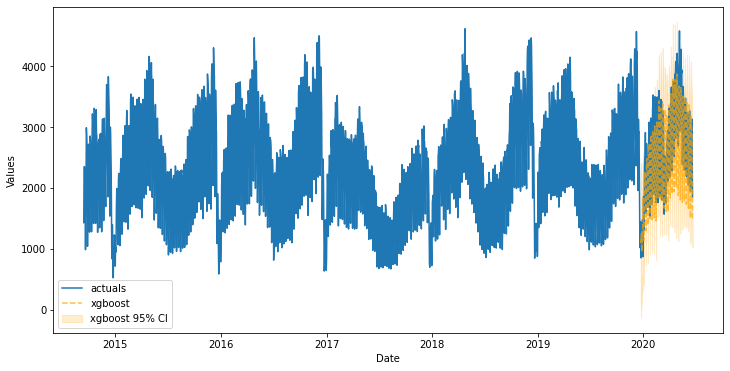

In [15]:
f.plot_test_set(ci=True,models=best_model)
plt.show()

The confidence interval is noticeable now and is dynamic -- for some observations it is further out from the point estimate than others. It has been constructed based on the dispersion of the point estimates from the other evaluated models.

In [16]:
fcsts2 = f.export("lvl_fcsts",cis=True)
results = score_cis(
    results,
    fcsts2,
    'Naive',
    visits_sep,
    visits,
    val_len = val_len,
)
results

Bootstrapped (Default)     Naive
mlr                       4.012824  5.557751
elasticnet                4.830622  5.510649
ridge                     4.614595  5.532300
knn                       3.635959  4.123267
xgboost                  21.443069  6.532696
lightgbm                 11.761339  7.180963
gbt                       8.563782  5.214933

### Backtested Interval

In [17]:
%%time
f.reeval_cis(method='backtest',jump_back=fcst_len)

Wall time: 2min 45s


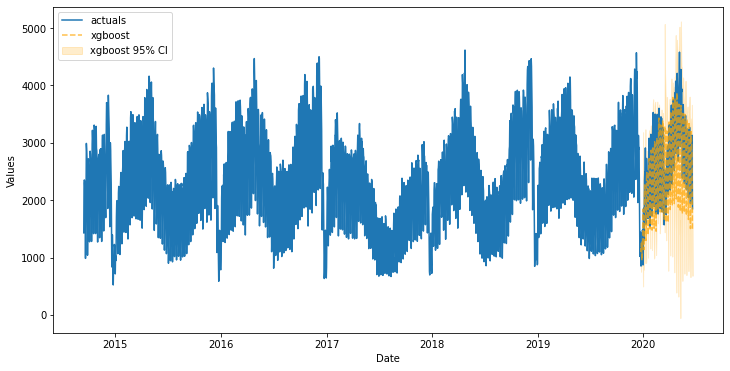

In [18]:
f.plot_test_set(ci=True,models=best_model)
plt.show()

This is also a dynamic confidence interval, but is obtained solely from XGBoost's own point estimates over 10 test sets in the data. The first point's interval is based on the standard deviation of the residual for all 10 tests of the first step, same for the second point and beyond.  

In [19]:
fcsts3 = f.export("lvl_fcsts",cis=True)
results = score_cis(
    results,
    fcsts3,
    'Backtest',
    visits_sep,
    visits,
    val_len = val_len,
)
results

Bootstrapped (Default)     Naive  Backtest
mlr                       4.012824  5.557751  5.354122
elasticnet                4.830622  5.510649  5.347150
ridge                     4.614595  5.532300  5.455698
knn                       3.635959  4.123267  7.166581
xgboost                  21.443069  6.532696  7.186355
lightgbm                 11.761339  7.180963  4.432147
gbt                       8.563782  5.214933  4.733465

### Aggregated Results  

- Which type generally led to the best MSIS score?  
- For website visitors, it was the naive method, but backtest was close.  

In [20]:
ci_type_score = results.mean()
ci_type_score.sort_values()

Naive                     5.664651
Backtest                  5.667931
Bootstrapped (Default)    8.408884
dtype: float64

In [21]:
model_score = results.mean(axis=1)
model_score.sort_values()

mlr            4.974899
knn            4.975269
ridge          5.200864
elasticnet     5.229473
gbt            6.170727
lightgbm       7.791483
xgboost       11.720706
dtype: float64

## Housing Starts  

- Link to data: https://fred.stlouisfed.org/series/HOUSTNSA  
- We will use a length of 96 observations (8 years) both to tune and test the models  
- We want to optimize the forecasts and confidence intervals for a 24-month forecast horizon  

In [22]:
import pandas_datareader as pdr

In [23]:
val_len = 96
fcst_len = 24

In [24]:
housing = pdr.get_data_fred('HOUSTNSA',start='1900-01-01',end='2021-06-01')

In [25]:
starts_sep = housing.iloc[-fcst_len:,0]
starts = housing.iloc[:-fcst_len,0]

In [26]:
f = Forecaster(
    y=starts,
    current_dates=starts.index,
    future_dates=fcst_len,
)

f.set_test_length(val_len)
f.set_validation_length(val_len)
f.diff()
f.auto_Xvar_select(
    estimator='elasticnet',
    alpha=.2,
    max_ar=100,
    monitor='ValidationMetricValue', # not test set
)
f

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2019-06-01T00:00:00.000000000
    Freq=MS
    N_actuals=726
    ForecastLength=24
    Xvars=['monthsin', 'monthcos', 'quartersin', 'quartercos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53', 'AR54', 'AR55', 'AR56', 'AR57', 'AR58', 'AR59', 'AR60', 'AR61', 'AR62', 'AR63', 'AR64', 'AR65', 'AR66', 'AR67', 'AR68', 'AR69', 'AR70', 'AR71', 'AR72', 'AR73', 'AR74', 'AR75', 'AR76', 'AR77', 'AR78', 'AR79', 'AR80', 'AR81', 'AR82', 'AR83', 'AR84', 'AR85', 'AR86', 'AR87', 'AR88', 'AR89', 'AR90', 'AR91', 'AR92', 'AR93', 'AR94', 'AR95', 'AR96', 'AR97', 'AR98'

In [27]:
tune_test_forecast(
    f,
    models,
    dynamic_testing = fcst_len,
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [28]:
ms = f.export('model_summaries',determine_best_by='LevelTestSetMAE')
best_model = ms['ModelNickname'].values[0]
ms[['ModelNickname','LevelTestSetMAE','LevelInSampleMAE']]

ModelNickname  LevelTestSetMAE  LevelInSampleMAE
0       xgboost        18.511642          2.230892
1      lightgbm        20.756320         22.575723
2           mlr        24.520401         60.741758
3           knn        40.900595        123.571497
4         ridge        41.370245         46.585394
5    elasticnet        49.169948         30.500771
6           gbt        57.329724         27.326541

### Bootstrapped Interval (default)

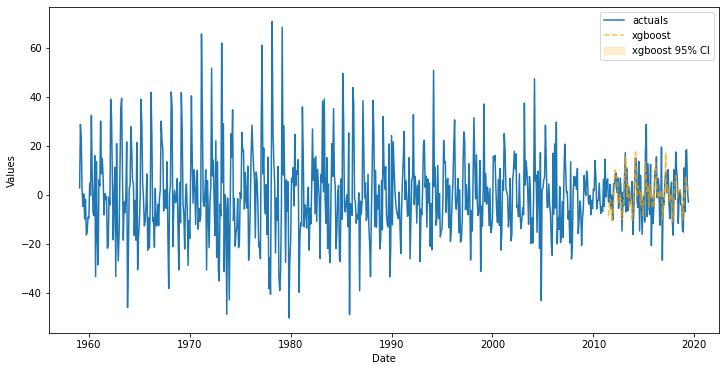

In [29]:
f.plot_test_set(ci=True,models=best_model)
plt.show()

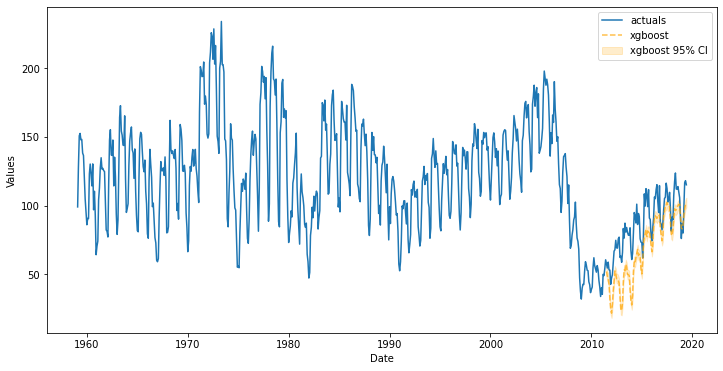

In [30]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [31]:
housing_fcsts1 = f.export("lvl_fcsts",cis=True)
housing_results = score_cis(
    results_template.copy(),
    housing_fcsts1,
    'Bootstrapped (Default)',
    starts_sep,
    starts,
    val_len = val_len,
    m_ = 12, # monthly seasonality
)
housing_results

Bootstrapped (Default)
mlr                       6.738584
elasticnet                6.086039
ridge                     6.809779
knn                      29.943329
xgboost                  28.521380
lightgbm                  6.062278
gbt                       5.216309

### Naive Interval

In [32]:
%%time
f.reeval_cis()

Wall time: 698 ms


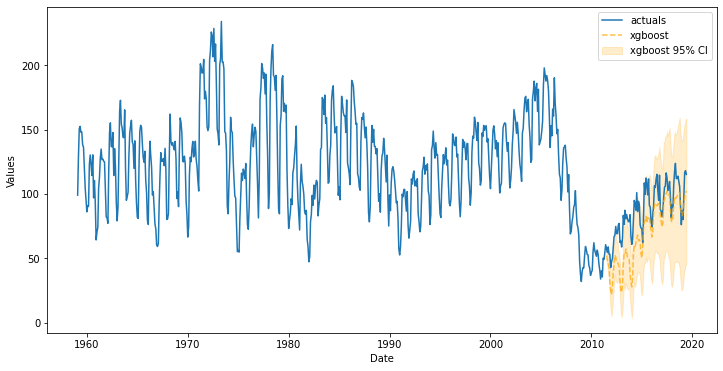

In [33]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [34]:
housing_fcsts2 = f.export("lvl_fcsts",cis=True)
housing_results = score_cis(
    housing_results,
    housing_fcsts2,
    'Naive',
    starts_sep,
    starts,
    val_len = val_len,
    m_ = 12,
)
housing_results

Bootstrapped (Default)      Naive
mlr                       6.738584  37.786260
elasticnet                6.086039  28.653637
ridge                     6.809779  32.322938
knn                      29.943329  32.783968
xgboost                  28.521380  20.904290
lightgbm                  6.062278  21.294740
gbt                       5.216309  30.242283

### Backtested Interval

In [35]:
%%time
f.reeval_cis(method='backtest',jump_back=fcst_len)

Wall time: 58.5 s


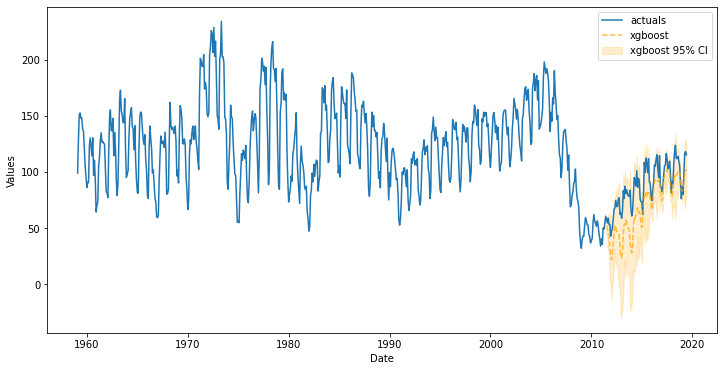

In [36]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [37]:
housing_fcsts3 = f.export("lvl_fcsts",cis=True)
housing_results = score_cis(
    housing_results,
    housing_fcsts3,
    'Backtest',
    starts_sep,
    starts,
    val_len = val_len,
    m_ = 12,
)
housing_results

Bootstrapped (Default)      Naive   Backtest
mlr                       6.738584  37.786260  29.674983
elasticnet                6.086039  28.653637   6.392320
ridge                     6.809779  32.322938  13.456166
knn                      29.943329  32.783968   6.940053
xgboost                  28.521380  20.904290   3.738981
lightgbm                  6.062278  21.294740   9.566699
gbt                       5.216309  30.242283   4.360395

### Aggregated Results  

- Which type generally led to the best MSIS score?  
- For housing starts, it was the backtest method.  

In [38]:
housing_ci_type_score = housing_results.mean()
housing_ci_type_score.sort_values()

Backtest                  10.589943
Bootstrapped (Default)    12.768243
Naive                     29.141160
dtype: float64

In [39]:
housing_model_score = housing_results.mean(axis=1)
housing_model_score.sort_values()

lightgbm      12.307906
gbt           13.272996
elasticnet    13.710666
ridge         17.529628
xgboost       17.721551
knn           23.222450
mlr           24.733276
dtype: float64

## Avocado Sales  

- Link to data: https://www.kaggle.com/datasets/neuromusic/avocado-prices.  
- We will use a length of 13 observations (1 quarter) both to tune and test the models  
- We want to optimize the forecasts and confidence intervals for a 13-week forecast horizon  

In [40]:
val_len = 13
fcst_len = 13

In [41]:
avocados = pd.read_csv('avocado.csv',parse_dates = ['Date'])
volume = avocados.groupby('Date')['Total Volume'].sum()

In [42]:
volume_sep = volume.iloc[-fcst_len:]
volume = volume.iloc[:-fcst_len]

In [43]:
f = Forecaster(
    y = volume,
    current_dates = volume.index,
    future_dates = 13,
)

f.set_test_length(fcst_len)
f.set_validation_length(val_len)
f.diff()
f.auto_Xvar_select(
    estimator='elasticnet',
    alpha=.2,
    max_ar=26,
    monitor='ValidationMetricValue', # not test set
)
f

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2017-12-24T00:00:00.000000000
    Freq=W-SUN
    N_actuals=156
    ForecastLength=13
    Xvars=['weeksin', 'weekcos', 'monthsin', 'monthcos', 'quartersin', 'quartercos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26']
    Differenced=1
    TestLength=13
    ValidationLength=13
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

In [44]:
tune_test_forecast(
    f,
    models,
    dynamic_testing = fcst_len,
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [45]:
ms = f.export('model_summaries',determine_best_by='LevelTestSetMAPE')
best_model = ms['ModelNickname'].values[0]
ms[['ModelNickname','LevelTestSetMAPE','LevelInSampleMAPE']]

ModelNickname  LevelTestSetMAPE  LevelInSampleMAPE
0           mlr          0.080165           0.623597
1         ridge          0.151771           0.095394
2    elasticnet          0.156035           0.086360
3      lightgbm          0.157319           0.118893
4           gbt          0.169125           0.032227
5           knn          0.189670           0.958267
6       xgboost          0.203372           0.000488

### Bootstrapped Interval (default)

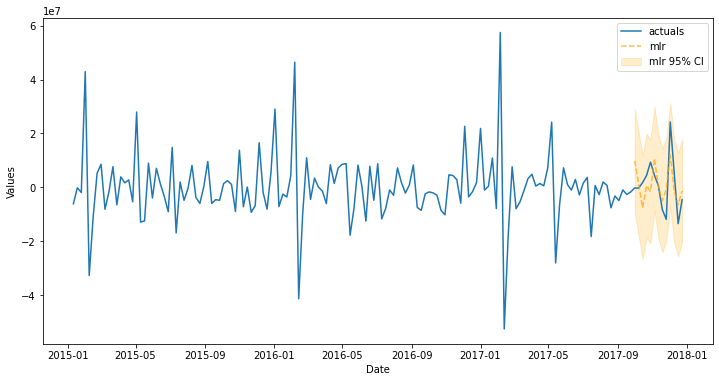

In [46]:
f.plot_test_set(ci=True,models=best_model)
plt.show()

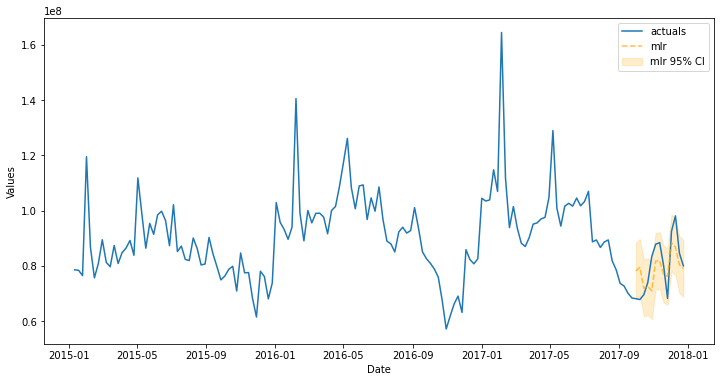

In [47]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [48]:
avc_fcsts1 = f.export("lvl_fcsts",cis=True)
avc_results = score_cis(
    results_template.copy(),
    avc_fcsts1,
    'Bootstrapped (Default)',
    volume_sep,
    volume,
    val_len = val_len,
    models = models,
)
avc_results

Bootstrapped (Default)
mlr                      64.124049
elasticnet               34.514332
ridge                    24.940104
knn                      50.742208
xgboost                  85.407882
lightgbm                 26.871321
gbt                      55.073546

### Naive Interval

In [49]:
%%time
f.reeval_cis()

Wall time: 180 ms


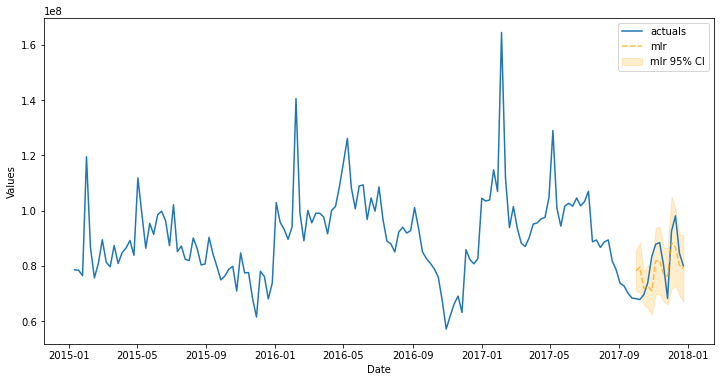

In [50]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [51]:
avc_fcsts2 = f.export("lvl_fcsts",cis=True)
avc_results = score_cis(
    avc_results,
    avc_fcsts2,
    'Naive',
    volume_sep,
    volume,
    val_len = val_len,
    models = models,
)
avc_results

Bootstrapped (Default)      Naive
mlr                      64.124049  38.802007
elasticnet               34.514332  39.118797
ridge                    24.940104  35.521791
knn                      50.742208  19.500294
xgboost                  85.407882  27.571250
lightgbm                 26.871321  29.247955
gbt                      55.073546  31.086468

### Backtested Interval

In [52]:
%%time
f.reeval_cis(method='backtest')

Wall time: 11.4 s


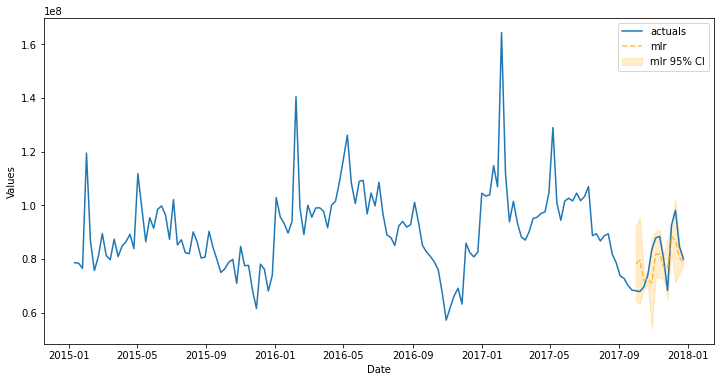

In [53]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [54]:
avc_fcsts3 = f.export("lvl_fcsts",cis=True)
avc_results = score_cis(
    avc_results,
    avc_fcsts3,
    'Backtest',
    volume_sep,
    volume,
    val_len = val_len,
    models = models,
)
avc_results

Bootstrapped (Default)      Naive   Backtest
mlr                      64.124049  38.802007  73.602343
elasticnet               34.514332  39.118797  49.809187
ridge                    24.940104  35.521791  44.957007
knn                      50.742208  19.500294  43.674854
xgboost                  85.407882  27.571250  27.445796
lightgbm                 26.871321  29.247955  35.425638
gbt                      55.073546  31.086468  34.975881

### Aggregated Results  

- Which type generally led to the best MSIS score?  
- For avocados, it was the naive method.  
- The default interval came in last for all examples, but it sometimes did best for individual models.  

In [55]:
avc_ci_type_score = avc_results.mean()
avc_ci_type_score.sort_values()

Naive                     31.549795
Backtest                  44.270101
Bootstrapped (Default)    48.810492
dtype: float64

In [56]:
avc_model_score = avc_results.mean(axis=1)
avc_model_score.sort_values()

lightgbm      30.514971
ridge         35.139634
knn           37.972452
gbt           40.378632
elasticnet    41.147438
xgboost       46.808309
mlr           58.842800
dtype: float64

## All Aggregated Results
- All MSIS scores for each model on each series are stored in the below dataframe.

In [57]:
all_results = {
    'visitors':results,
    'housing starts':housing_results,
    'avocados':avc_results
}

all_results_df = pd.DataFrame()
for k, df in all_results.items():
    df['forecast of'] = k
    all_results_df = pd.concat(
        [all_results_df,df]
    )
    
all_results_df

Bootstrapped (Default)      Naive   Backtest     forecast of
mlr                       4.012824   5.557751   5.354122        visitors
elasticnet                4.830622   5.510649   5.347150        visitors
ridge                     4.614595   5.532300   5.455698        visitors
knn                       3.635959   4.123267   7.166581        visitors
xgboost                  21.443069   6.532696   7.186355        visitors
lightgbm                 11.761339   7.180963   4.432147        visitors
gbt                       8.563782   5.214933   4.733465        visitors
mlr                       6.738584  37.786260  29.674983  housing starts
elasticnet                6.086039  28.653637   6.392320  housing starts
ridge                     6.809779  32.322938  13.456166  housing starts
knn                      29.943329  32.783968   6.940053  housing starts
xgboost                  28.521380  20.904290   3.738981  housing starts
lightgbm                  6.062278  21.294740   9.566699  housing starts
gbt                       5.216309  30.242283   4.360395  housing starts
mlr                      64.124049  38.802007  73.602343        avocados
elasticnet               34.514332  39.118797  49.809187        avocados
ridge                    24.940104  35.521791  44.957007        avocados
knn                      50.742208  19.500294  43.674854        avocados
xgboost                  85.407882  27.571250  27.445796        avocados
lightgbm                 26.871321  29.247955  35.425638        avocados
gbt                      55.073546  31.086468  34.975881        avocados

In [58]:
all_results_df.mean().sort_values()

Backtest                  20.175991
Naive                     22.118535
Bootstrapped (Default)    23.329206
dtype: float64

Generally speaking, the backtest interval was the best, followed by naive, followed by bootstrapped. All three of them were fairly close to one another.  

In [122]:
models_pivoted = pd.pivot_table(
    all_results_df.reset_index(),
    index = 'index',
    values = all_results_df.columns.to_list()[:-1],
    aggfunc = np.mean,
    sort = False,
)
models_pivoted

Bootstrapped (Default)      Naive   Backtest
index                                                   
mlr                      24.958486  27.382006  36.210483
elasticnet               15.143664  24.427694  20.516219
ridge                    12.121493  24.459010  21.289624
knn                      28.107165  18.802510  19.260496
xgboost                  45.124110  18.336079  12.790377
lightgbm                 14.898313  19.241219  16.474828
gbt                      22.951213  22.181228  14.689913

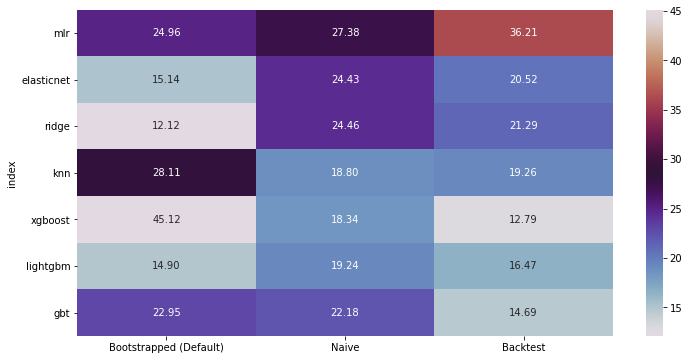

In [137]:
_, ax = plt.subplots(figsize=(12,6))
sns.heatmap(
    models_pivoted,
    annot=True,
    fmt='.2f',
    cmap="twilight",
    ax=ax
)
plt.show()

Bootstrapped intervals seem to have a good or bad score, without a lot in the middle. Naive is more in the middle of the three methods and most of the backtest intervals score well, with MLR skewing those results.

## Benchmark Against StatsModels ARIMA
- Confidence intervals come from StatsModels but the auto-ARIMA process is from [PMDARIMA](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima).

In [126]:
from scalecast.auxmodels import auto_arima

In [127]:
all_series = {
    # series,out-of-sample series,seasonal step
    'visitors':[visits,visits_sep,1],
    'housing starts':[starts,starts_sep,12],
    'avocados':[volume,volume_sep,1]
}
arima_benchmark_results = pd.DataFrame()

In [138]:
for k, v in all_series.items():
    print(k)
    f = Forecaster(
        y=v[0],
        current_dates=v[0].index,
        future_dates=len(v[1])
    )
    auto_arima(f,m=v[2])
    cis = f.regr.get_forecast(len(v[1])).conf_int()
    arima_benchmark_results.loc[k,'MSIS'] = metrics.msis(
        a = v[0].values,
        uf = cis.T[1],
        lf = cis.T[0],
        obs = v[1].values,
        m = v[2],
    )

visitors
housing starts
avocados


In [139]:
arima_benchmark_results

MSIS
visitors        0.278138
housing starts  0.399515
avocados        0.400816

In [140]:
arima_benchmark_results.mean()

MSIS    0.35949
dtype: float64

On average, the scalecast metrics scored better than the ARIMA confidence intervals over all models and series and scalecast also scored better as an average of all models on every series individually. There were no models run on the visitors series that scored as poorly as ARIMA. Same with the housing series. Several models scored worse on avocados under the bootstrapped and backtest framework, but none using naive.